In [19]:
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import arviz as az
import scipy.stats as stats

In [294]:
df = pd.read_csv('per_game_data.csv').drop('Unnamed: 0', axis=1)

X = df[['GS', 'MP', 'FGA', '2PA', '3PA', 'FTA', 'DRB', 'TOV']]
y = df['PTS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- **Parameter Prior Distribution:**
  - $\theta \sim \mathcal{N}(\mu, \Sigma)$  
    This defines the prior distribution of the parameters $\theta$ as a multivariate normal distribution with mean vector $\mu$ and covariance matrix $\Sigma$.

- **Parameter Initialization Distribution:**
  - $\theta_0 \sim \mathcal{N}(0, I)$  
    This specifies the initial distribution of parameters $\theta_0$ as a multivariate normal distribution with a mean of zero and the identity matrix as the covariance (indicating independence and unit variance).

- **Optimization Objective:**
  - $\mu^*, \Sigma^* = \arg\min_{\mu,\Sigma} \sum_{(x_i, y_i) \in D_{tr}} \mathcal{L}(F_{\theta}(x_i), y_i) + KL[p(\theta) \| p(\theta_0)]$  
    This equation is the objective function for optimization. It is finding the optimal parameters $\mu^*$ and $\Sigma^*$ that minimize the sum of the loss function $\mathcal{L}$ over the training data $D_{tr}$, plus the Kullback-Leibler divergence between the current parameter distribution $p(\theta)$ and the initial parameter distribution $p(\theta_0)$.

- **Prediction:**
  - $p(y | \hat{x}, D_{tr}) = \int p(y | \hat{x}, \theta^*) p(\theta^* | D_{tr}) d\theta^*$  
    This equation describes the predictive distribution for a new input $\hat{x}$, integrating over all possible parameter values $\theta^*$, weighted by their posterior probability given the training data $D_{tr}$.

- **Posterior Parameter Distribution:**
  - $\theta^* \sim \mathcal{N}(\mu^*, \Sigma^*)$  
    This defines the posterior distribution of the parameters $\theta^*$ after training as a multivariate normal distribution with the optimized mean $\mu^*$ and covariance $\Sigma^*$.

- **Prediction Estimation:**
  - $\hat{y} = \frac{1}{K} \sum_{k=1}^{K} F_{\theta^*_k}(\hat{x})$  
    This is the final prediction for a new input $\hat{x}$, obtained by averaging the predictions from $K$ different parameter sets $\theta^*_k$, each drawn from the posterior distribution.

- **Individual Posterior Sample Distribution:**
  - $\theta^*_k \sim \mathcal{N}(\mu^*, \Sigma^*)$  
    Each $\theta^*_k$ is a sample from the posterior distribution of the parameters used for making individual predictions that are then averaged to compute $\hat{y}$.


In [353]:
# Initialize random weights between each layer
# init_1 = np.random.randn(X.shape[1], n_hidden)
# init_2 = np.random.randn(n_hidden, n_hidden)
# init_out = np.random.randn(n_hidden)

def construct_nn(ann_input, ann_output):
    n_hidden = 8

    # He Initializations
    init_1 = np.random.randn(X_train_scaled.shape[1], n_hidden) * np.sqrt(2. / X_train_scaled.shape[1])
    init_2 = np.random.randn(n_hidden, n_hidden) * np.sqrt(2. / n_hidden)
    init_out = np.random.randn(n_hidden) * np.sqrt(2. / n_hidden)

    with pm.Model() as BayesianNN:
        ann_input = pm.Data('ann_input', X_train_scaled, mutable=True)
        ann_output = pm.Data('ann_output', y_train, mutable=True)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=2,
                                 shape=(X.shape[1], n_hidden),
                                 initval=init_1)
        
        # Bias for first hidden layer
        bias_1 = pm.Normal('b_1', 0, sigma=1, shape=(n_hidden,), initval=np.zeros(n_hidden))

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=2,
                                shape=(n_hidden, n_hidden),
                                initval=init_2)
        
        # Bias for second hidden layer
        bias_2 = pm.Normal('b_2', 0, sigma=2, shape=(n_hidden,), initval=np.zeros(n_hidden))
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  initval=init_out)

        # Bias for output layer
        bias_out = pm.Normal('b_out', 0, sigma=2, shape=(1,), initval=np.zeros(1))

        # PReLU parameters
        alpha_1 = pm.Uniform('alpha_1', lower=0, upper=0.5, shape=(n_hidden,))
        alpha_2 = pm.Uniform('alpha_2', lower=0, upper=0.5, shape=(n_hidden,))

        # Neural network architecture using PReLU
        z_1 = pm.math.dot(ann_input, weights_in_1) + bias_1
        act_1 = pm.math.switch(z_1 < 0, alpha_1 * z_1, z_1)
        
        z_2 = pm.math.dot(act_1, weights_1_2) + bias_2
        act_2 = pm.math.switch(z_2 < 0, alpha_2 * z_2, z_2)

        act_out = pm.math.dot(act_2, weights_2_out) + bias_out

        
        sigma = pm.HalfNormal('sigma', sigma=4)  # Scale parameter
        nu = pm.Exponential('nu', 1/30)  # Degrees of freedom parameter

        # Likelihood (how well our model represents the data)
        out = pm.StudentT('out', mu=act_out, sigma=sigma, nu=nu, observed=ann_output, shape=act_out.shape)


    return BayesianNN


c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(


Finished [100%]: Average Loss = 27,997


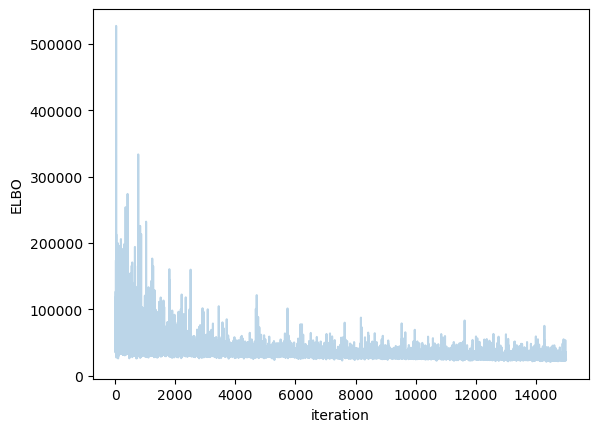

In [357]:
minibatch_x = pm.Minibatch(X_train_scaled, batch_size=1024)
minibatch_y = pm.Minibatch(y_train, batch_size=1024)
bnn = construct_nn(minibatch_x, minibatch_y)

with bnn:
    approx = pm.fit(n=15000, method= 'advi')

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO");
plt.xlabel("iteration");

In [358]:
trace = approx.sample(draws=3000)

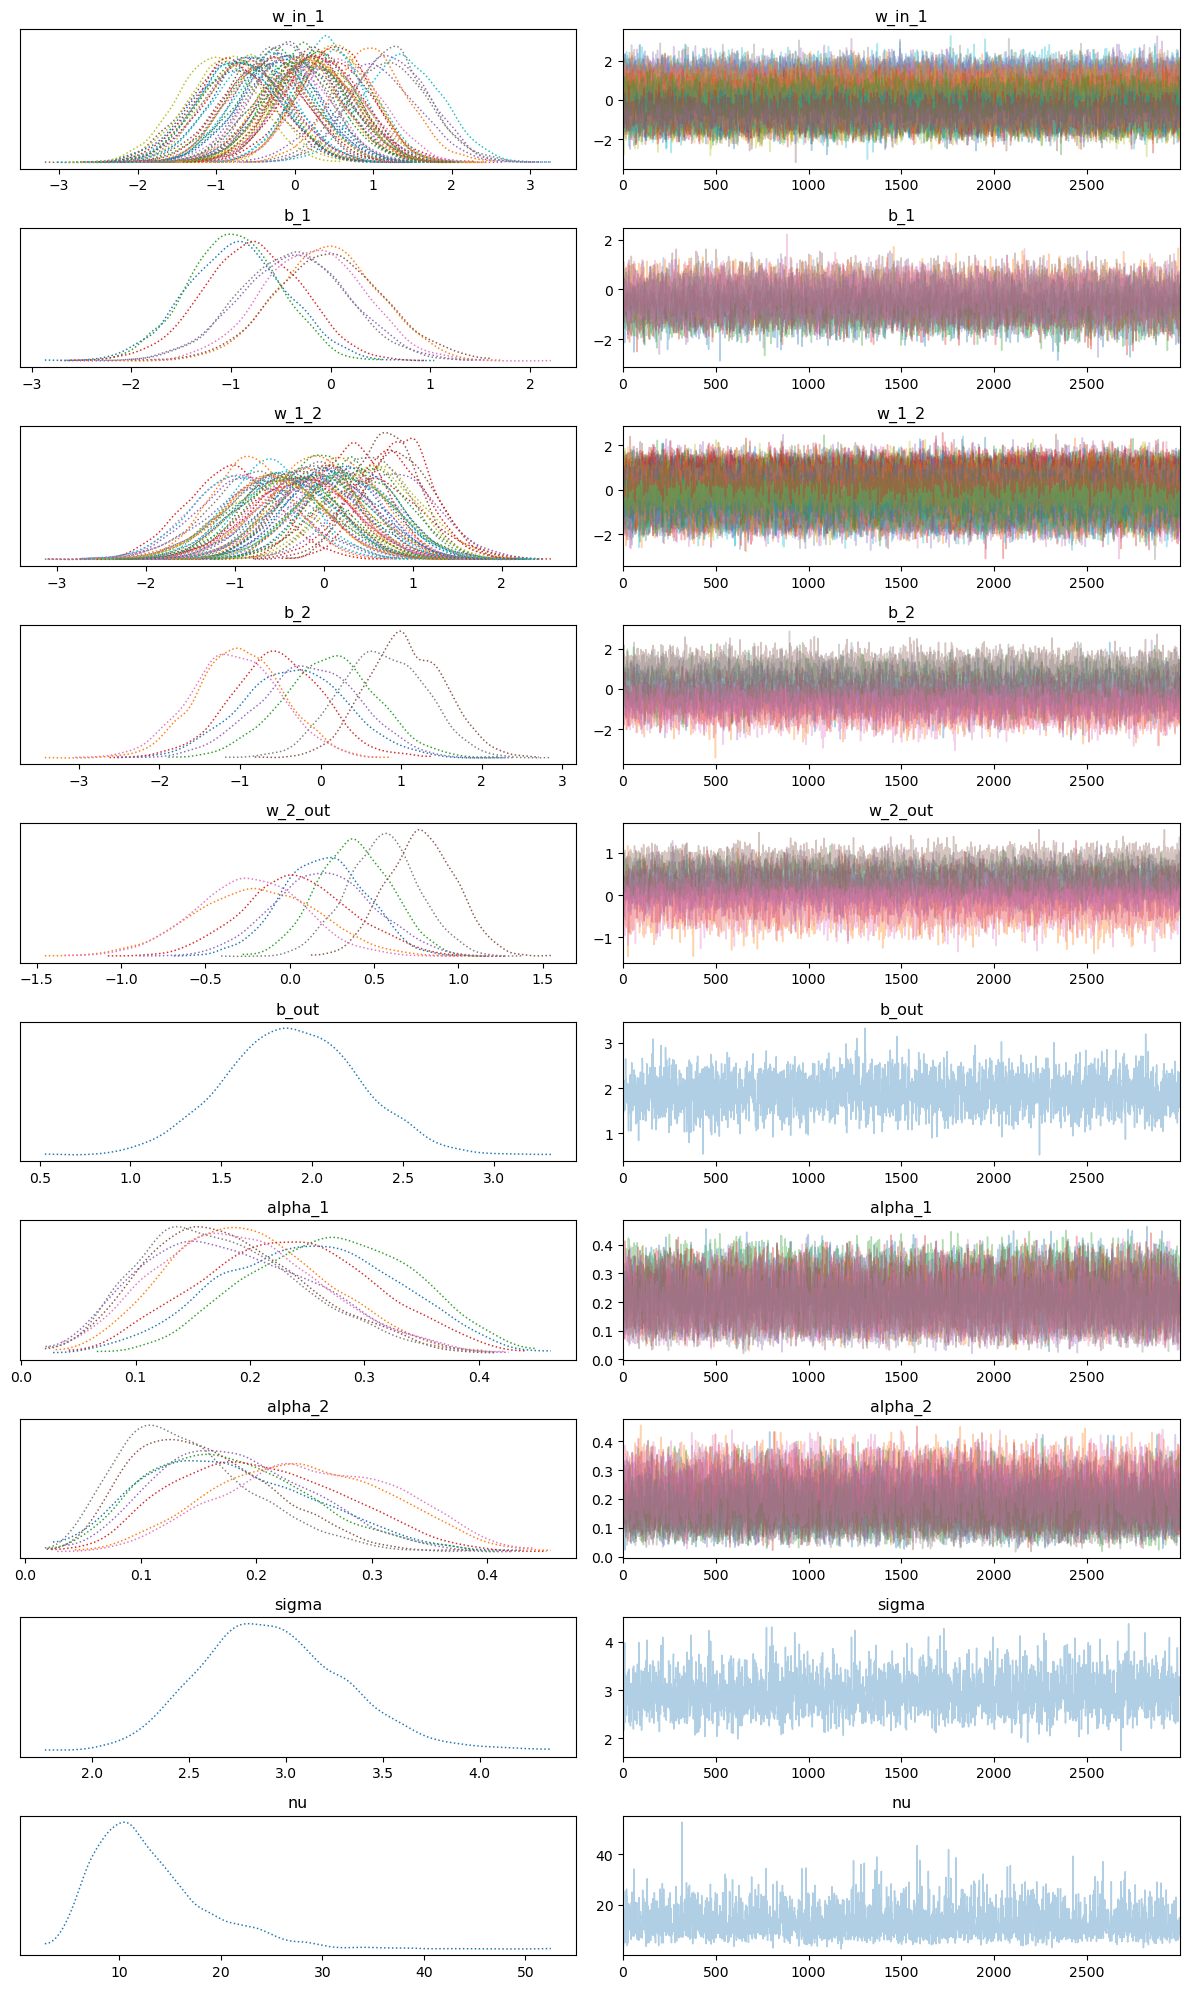

In [359]:
az.plot_trace(trace, combined=True)
plt.tight_layout()

c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (171) in plot_posterior, generating only 40 plots
  warnings.warn(


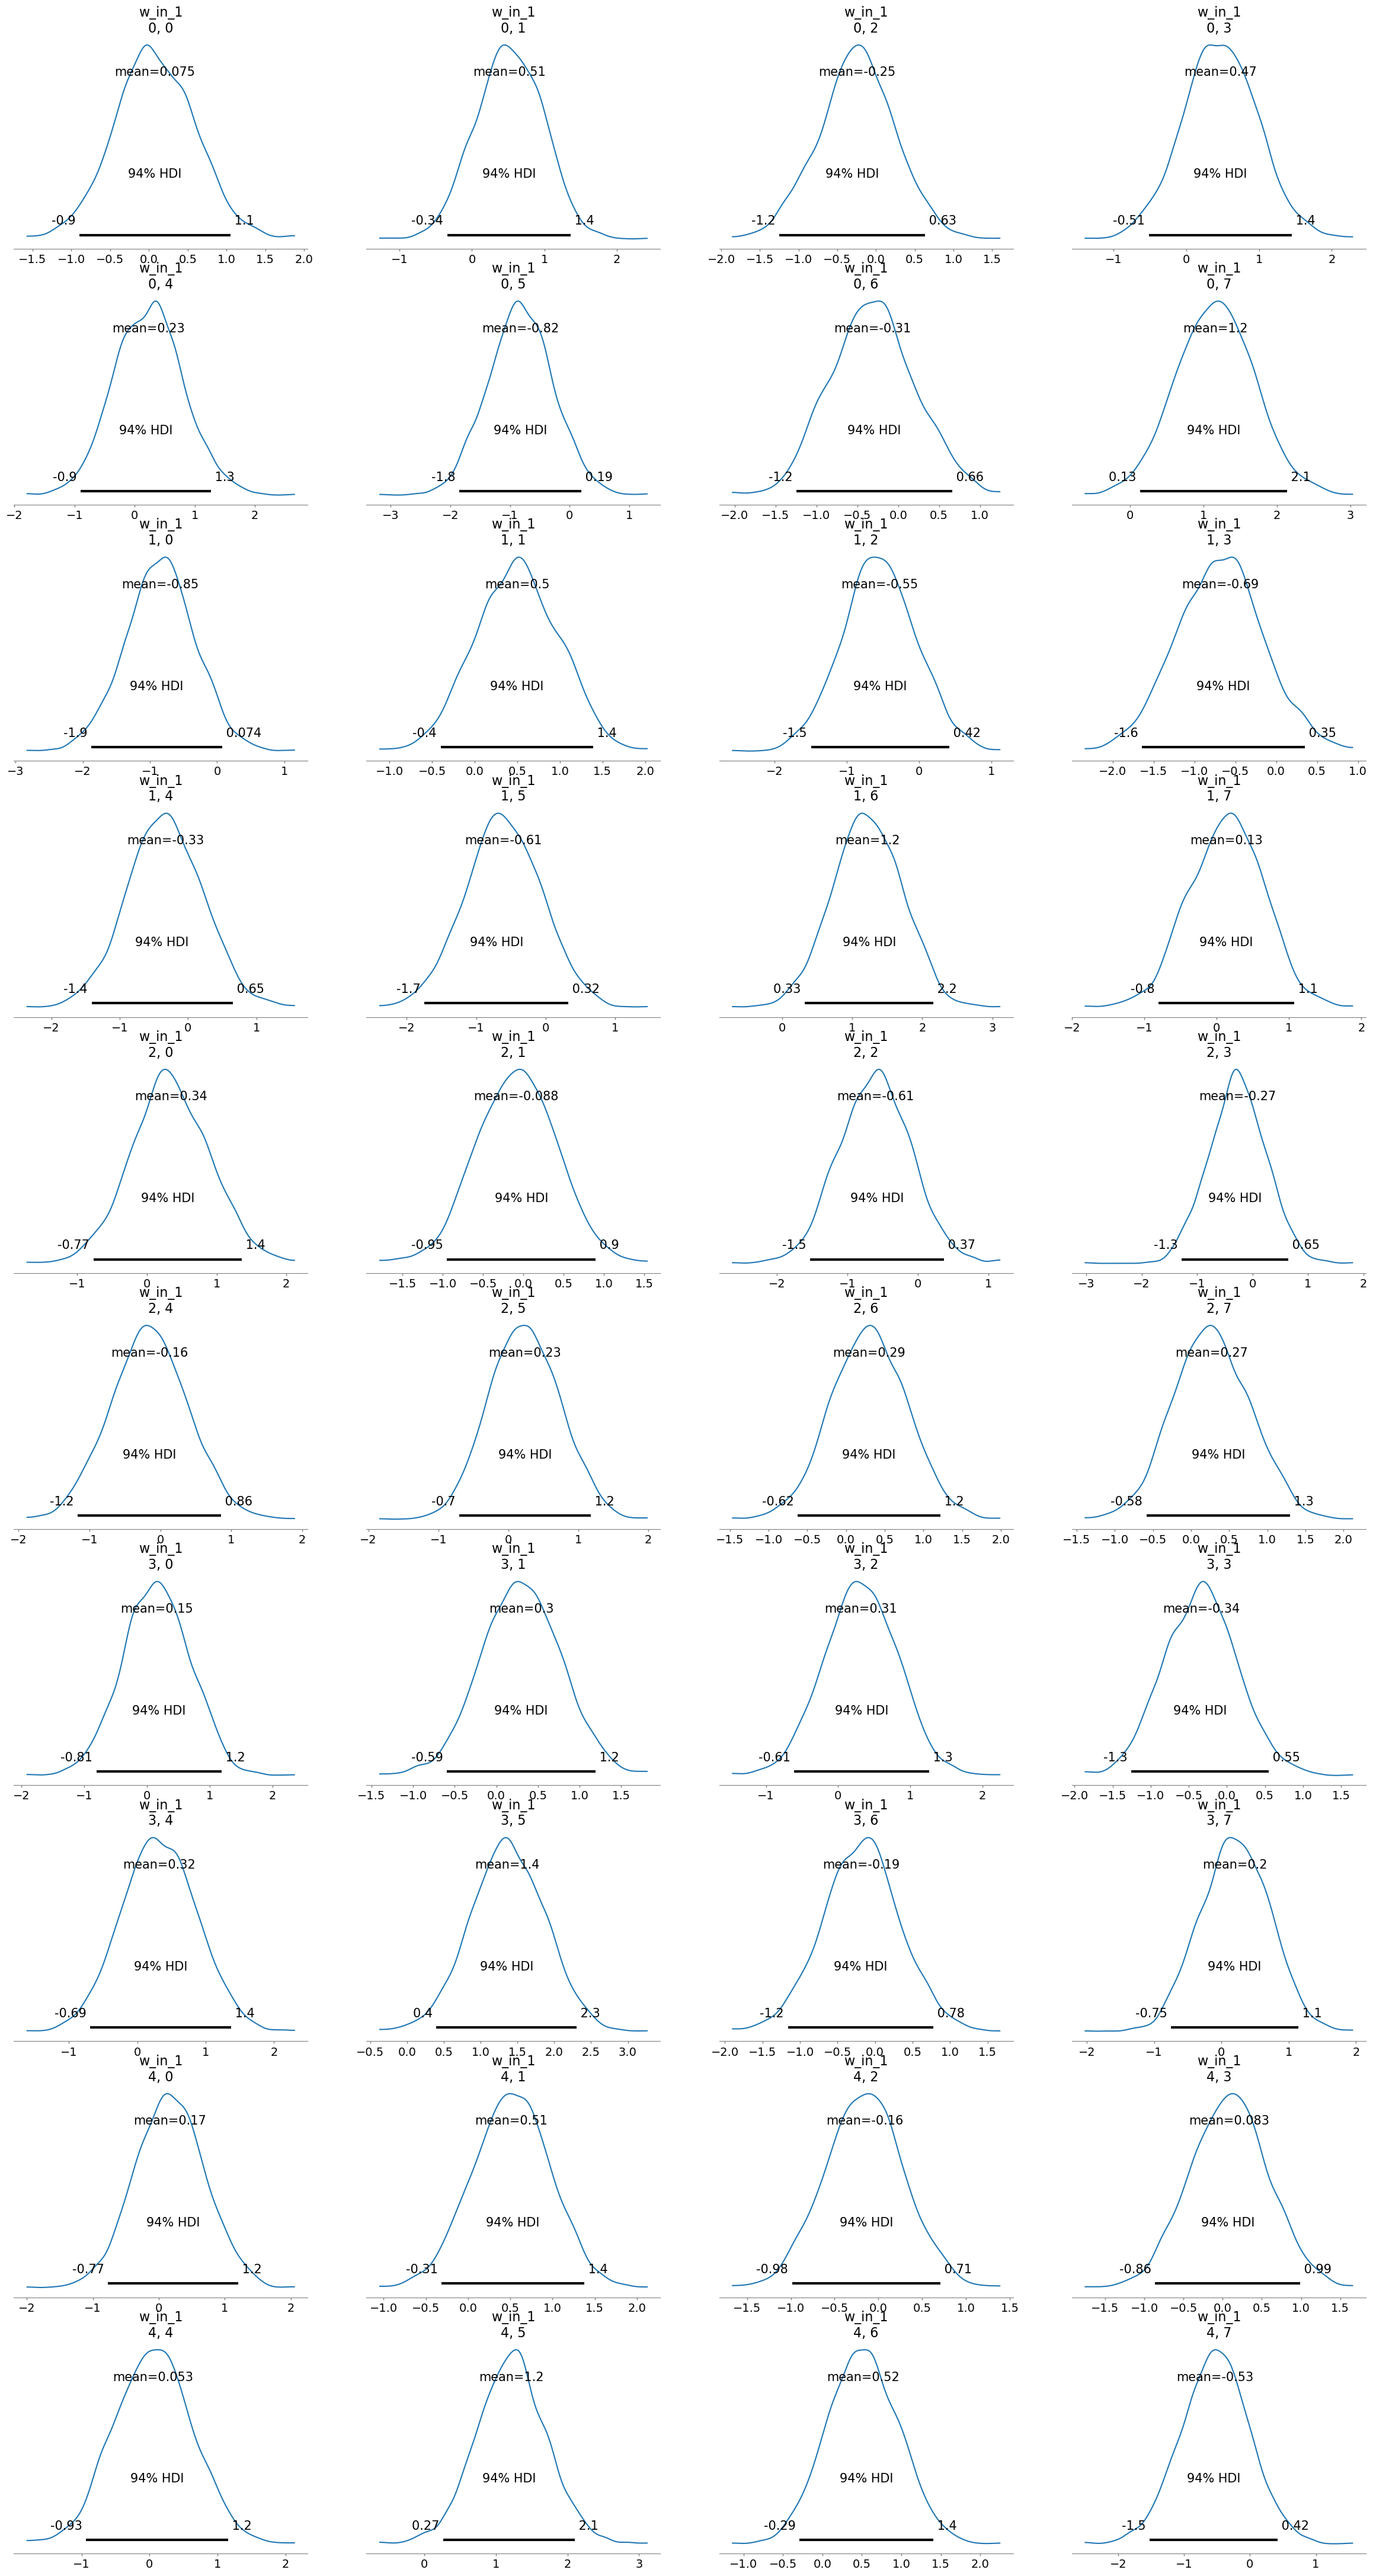

In [360]:
az.plot_posterior(trace);

In [361]:
with bnn:
    pm.set_data(new_data={"ann_input": X_test_scaled})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


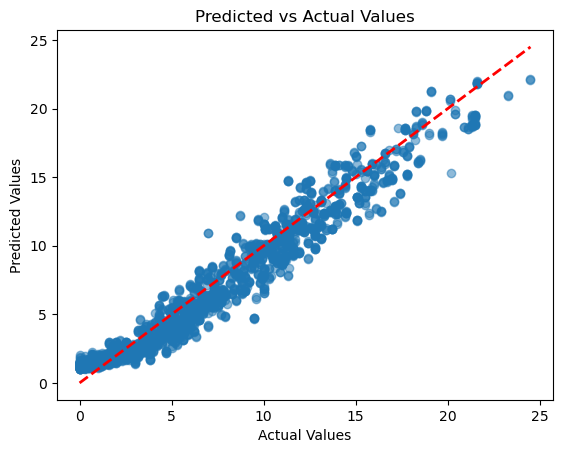

In [383]:
plt.scatter(y_test, pred, alpha=0.5)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plot a line representing the perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, ls='--')

plt.show()

In [408]:
all_players = df[df['Year'] == 2024]
numerical_cols = ['GS', 'MP', 'FGA', '2PA', '3PA', 'FTA', 'DRB', 'TOV']
all_players_numerical = all_players[numerical_cols]
scaled_features = scaler.transform(all_players_numerical)
scaled_features_df = pd.DataFrame(scaled_features, columns=numerical_cols)
scaled_features_df


,GS,MP,FGA,2PA,3PA,FTA,DRB,TOV
0,1.435021,1.393295,2.341654,1.925180,2.055601,1.580419,0.904165,0.531215
1,-0.783858,0.654978,1.678489,1.411994,1.427983,0.994017,0.463628,1.701302
2,-0.506498,1.165420,0.836779,0.238999,1.375681,0.277304,1.155900,1.701302
3,0.810961,1.293030,0.811273,0.715529,0.643460,0.863705,2.162841,0.823736
4,1.088321,0.882854,1.066336,0.972121,0.800365,0.407615,-0.165710,0.969997
...,...,...,...,...,...,...,...,...
894,-0.853198,-1.295636,-1.050690,-0.897340,-0.873285,-0.504565,-1.046784,-0.492612
895,-0.853198,-1.013070,-0.948665,-0.860684,-0.716380,-0.504565,-1.235585,-0.053829
896,-0.853198,-0.675815,-0.948665,-0.860684,-0.716380,-0.634877,-0.920916,-0.346351
897,-0.853198,-1.304751,-0.923159,-0.970652,-0.454872,-1.025811,-1.172651,-1.223916


In [420]:
all_players_scaled = all_players.reset_index(drop='index')[['Player', 'Team']].join(scaled_features_df)
all_players_scaled

,Player,Team,GS,MP,FGA,2PA,3PA,FTA,DRB,TOV
0,Antonio Reeves,Kentucky,1.435021,1.393295,2.341654,1.925180,2.055601,1.580419,0.904165,0.531215
1,Rob Dillingham,Kentucky,-0.783858,0.654978,1.678489,1.411994,1.427983,0.994017,0.463628,1.701302
2,Reed Sheppard,Kentucky,-0.506498,1.165420,0.836779,0.238999,1.375681,0.277304,1.155900,1.701302
3,Tre Mitchell,Kentucky,0.810961,1.293030,0.811273,0.715529,0.643460,0.863705,2.162841,0.823736
4,D.J. Wagner,Kentucky,1.088321,0.882854,1.066336,0.972121,0.800365,0.407615,-0.165710,0.969997
...,...,...,...,...,...,...,...,...,...,...
894,Jaylen Dorsey,Western Kentucky,-0.853198,-1.295636,-1.050690,-0.897340,-0.873285,-0.504565,-1.046784,-0.492612
895,Fallou Diagne,Western Kentucky,-0.853198,-1.013070,-0.948665,-0.860684,-0.716380,-0.504565,-1.235585,-0.053829
896,Jack Edelen,Western Kentucky,-0.853198,-0.675815,-0.948665,-0.860684,-0.716380,-0.634877,-0.920916,-0.346351
897,Tyler Olden,Western Kentucky,-0.853198,-1.304751,-0.923159,-0.970652,-0.454872,-1.025811,-1.172651,-1.223916


In [424]:
# Predict expected points for each player
with bnn:
    pm.set_data(new_data={"ann_input": scaled_features})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


In [427]:
expected_pts = ppc.posterior_predictive["out"].mean(("chain", "draw"))
all_players_scaled['EPTS'] = expected_pts
all_players_scaled

,Player,Team,GS,MP,FGA,2PA,3PA,FTA,DRB,TOV,EPTS
0,Antonio Reeves,Kentucky,1.435021,1.393295,2.341654,1.925180,2.055601,1.580419,0.904165,0.531215,15.285076
1,Rob Dillingham,Kentucky,-0.783858,0.654978,1.678489,1.411994,1.427983,0.994017,0.463628,1.701302,13.262436
2,Reed Sheppard,Kentucky,-0.506498,1.165420,0.836779,0.238999,1.375681,0.277304,1.155900,1.701302,11.347005
3,Tre Mitchell,Kentucky,0.810961,1.293030,0.811273,0.715529,0.643460,0.863705,2.162841,0.823736,10.962910
4,D.J. Wagner,Kentucky,1.088321,0.882854,1.066336,0.972121,0.800365,0.407615,-0.165710,0.969997,9.261201
...,...,...,...,...,...,...,...,...,...,...,...
894,Jaylen Dorsey,Western Kentucky,-0.853198,-1.295636,-1.050690,-0.897340,-0.873285,-0.504565,-1.046784,-0.492612,1.794865
895,Fallou Diagne,Western Kentucky,-0.853198,-1.013070,-0.948665,-0.860684,-0.716380,-0.504565,-1.235585,-0.053829,2.036415
896,Jack Edelen,Western Kentucky,-0.853198,-0.675815,-0.948665,-0.860684,-0.716380,-0.634877,-0.920916,-0.346351,2.153657
897,Tyler Olden,Western Kentucky,-0.853198,-1.304751,-0.923159,-0.970652,-0.454872,-1.025811,-1.172651,-1.223916,1.261710


In [432]:
all_players_scaled.to_csv('bnn_expected_pts_per_player.csv')

Team Performance

In [60]:
df=pd.read_html('https://www.sports-reference.com/cbb/seasons/men/2024-polls.html')[1]
df.columns = df.columns.get_level_values(1)
df.rename(columns={'Unnamed: 0_level_1': 'School', 'Unnamed: 1_level_1': 'Conference'}, inplace=True)
df=df.fillna(26)
new_df=df.drop([20, 21]).reset_index().drop('index', axis=1)[0:]
new_df

,School,Conference,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,Alabama,SEC,24,22,17,23,26,26,26,26,...,26,26,24,16,15,13,14,16,19,19
1,Arizona,Pac-12,12,3,3,2,1,1,4,4,...,12,9,11,8,5,4,6,5,6,9
2,Arkansas,SEC,14,14,20,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
3,Auburn,SEC,26,26,26,26,26,26,26,26,...,13,8,16,12,13,14,11,13,12,7
4,BYU,Big 12,26,26,26,19,14,18,17,14,...,20,21,22,21,19,25,26,20,20,21
5,Baylor,Big 12,20,15,13,9,6,6,10,17,...,9,15,18,13,12,11,15,11,14,14
6,Clemson,ACC,26,26,26,26,24,13,18,18,...,26,26,26,26,26,26,26,26,26,26
7,Colorado,Pac-12,26,25,18,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
8,Colorado State,MWC,26,26,26,20,13,17,16,15,...,26,24,26,26,26,22,26,26,26,26
9,Creighton,Big East,8,8,8,15,10,8,12,22,...,18,17,13,19,17,15,12,10,8,11


In [61]:
pairwise_matchups = new_df.drop(['School', 'Conference'], axis=1).reset_index().drop('index', axis=1).astype(int).transpose()
pairwise_matchups
matchups = []
ranking_set={}
counter=1
for k, row in pairwise_matchups.iterrows():
    for i in range(len(row)):
        for j in range(i + 1, len(row)):
            # If team i has a lower rank than team j, it wins
            if row[i] < row[j]:
                ranking_set[(i,j,counter)]=0
                counter+=1
            elif row[i] > row[j]:
                ranking_set[(i,j,counter)]=1
                counter+=1

df_rankings = pd.DataFrame(list(ranking_set.keys()), columns=['player0', 'player1', 'Matchup Number'])
df_rankings['y'] = list(ranking_set.values())
df_rankings=df_rankings[['player0', 'player1', 'y']]
df_rankings

,player0,player1,y
0,0,1,1
1,0,2,1
2,0,3,0
3,0,4,0
4,0,5,1
...,...,...,...
18995,47,49,1
18996,47,50,1
18997,48,49,1
18998,48,50,1


In [4]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=1, shape=51)
    logit = alpha[df_rankings['player1']] - alpha[df_rankings['player0']]
    y_obs = pm.Bernoulli('y_obs', logit_p=logit, observed=df_rankings['y'])

with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

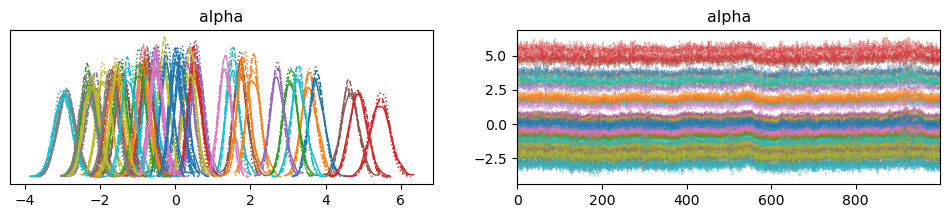

In [5]:
az.plot_trace(idata)

In [6]:
results_2023=pd.read_csv('2023_results.csv')
results_2022=pd.read_csv('2022_results.csv')
results_2021=pd.read_csv('2021_results.csv')

results=pd.concat([results_2023, results_2022, results_2021])
results

,Unnamed: 0,TeamA,TeamB,PaseA,PaseB,Year,Round,A_win,AlphaA,AlphaB
0,0,TCU,Arizona State,-0.7,-1.9,2023,1,1,0.865075,-2.617577
1,1,Kansas,Arkansas,-1.8,3.5,2023,2,0,3.733992,0.925478
2,2,Houston,Auburn,2.1,1.4,2023,2,1,5.051271,0.607027
3,3,Iowa,Auburn,-2.6,1.4,2023,1,0,-2.613065,0.607027
4,4,Creighton,Baylor,0.9,-0.3,2023,2,1,0.245640,2.122230
...,...,...,...,...,...,...,...,...,...,...
58,58,Florida,Virginia Tech,5.9,-2.1,2021,1,1,-2.755354,0.336502
59,59,Syracuse,West Virginia,4.7,-0.2,2021,2,1,-2.896739,1.826773
60,60,Villanova,Winthrop,4.0,-1.0,2021,1,1,2.840743,-2.896739
61,61,Baylor,Wisconsin,-0.3,4.0,2021,2,1,5.247662,1.176380


In [7]:
with pm.Model() as logit_wins_BT:

    #Assigning non-BT priors
    beta_pase_A = pm.Normal("beta_pase_A", mu = 0, sigma = 0.5)
    beta_pase_B = pm.Normal("beta_pase_B", mu = 0, sigma = 0.5)
    beta_alphaA = pm.Normal("beta_alphaA", mu = 0, sigma = 0.5)
    beta_alphaB = pm.Normal("beta_alphaB", mu = 0, sigma = 0.5)

    #Regression using some of this code https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/
    likelihood = pm.invlogit(beta_pase_A*results.PaseA + beta_pase_B*results.PaseB + beta_alphaA*results.AlphaA + beta_alphaB*results.AlphaB)
    logit = pm.Bernoulli("logit", p = likelihood, observed = results.A_win)

with logit_wins_BT:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pase_A, beta_pase_B, beta_alphaA, beta_alphaB]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'beta_pase_A'}>,
        <Axes: title={'center': 'beta_pase_A'}>],
       [<Axes: title={'center': 'beta_pase_B'}>,
        <Axes: title={'center': 'beta_pase_B'}>],
       [<Axes: title={'center': 'beta_alphaA'}>,
        <Axes: title={'center': 'beta_alphaA'}>],
       [<Axes: title={'center': 'beta_alphaB'}>,
        <Axes: title={'center': 'beta_alphaB'}>]], dtype=object)

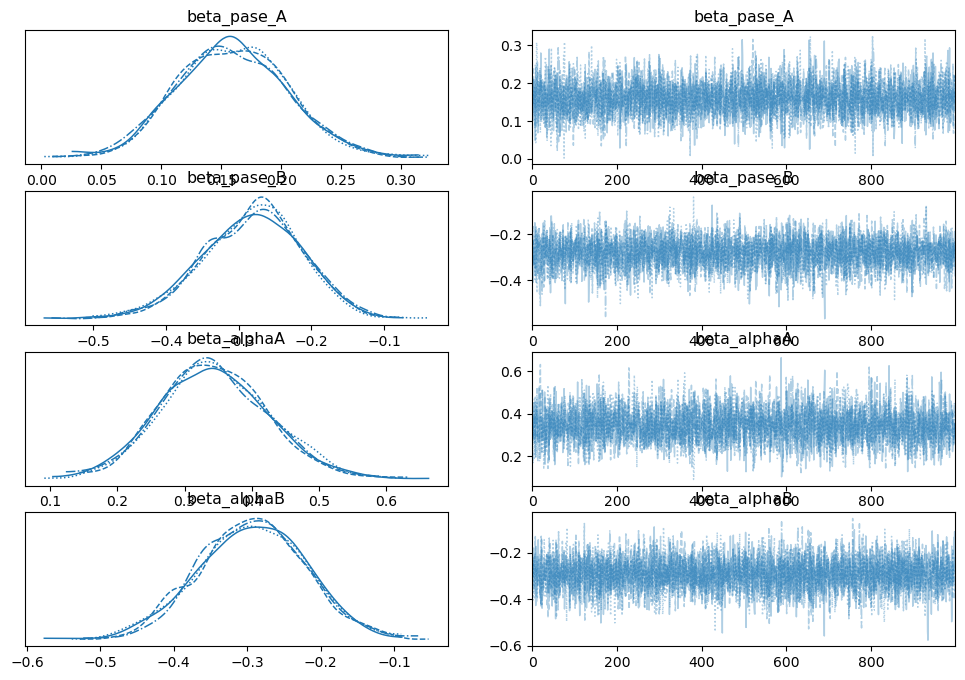

In [8]:
az.plot_trace(idata)

In [9]:
mean_betaPA = np.mean(idata['posterior']['beta_pase_A'], axis=(0,1))
mean_betaPB = np.mean(idata['posterior']['beta_pase_B'], axis=(0,1))
mean_betaAA = np.mean(idata['posterior']['beta_alphaA'], axis=(0,1))
mean_betaAB = np.mean(idata['posterior']['beta_alphaB'], axis=(0,1))

In [10]:
new_mm = pd.read_csv('https://raw.githubusercontent.com/juliacmurray/STA365/main/STA365%20PASE%20and%20ALPHA%20MM%202024.csv')
mm_pase=new_mm[['Team', 'PASE']]

In [11]:
team_alphas=pd.read_csv('team_alphas.csv')

In [14]:
data_merged = pd.merge(mm_pase, team_alphas, left_on='Team', right_on='School', how='left')
data_merged.rename(columns={'alpha': 'AlphaA'}, inplace=True)
data_merged.drop(columns='School', inplace=True)
data_merged.drop(columns='Unnamed: 0', inplace=True)
data_merged

,Team,PASE,AlphaA
0,Akron,-1.1,-3.498812
1,Alabama,-2.9,1.682071
2,Arizona,-2.5,5.150354
3,Auburn,1.4,2.176298
4,Baylor,-0.3,3.374963
...,...,...,...
59,Wagner,0.0,-3.499253
60,Washington State,-0.1,0.451716
61,Western Kentucky,2.0,-3.512407
62,Wisconsin,4.0,1.713742


In [33]:
import random
random.seed(1006693507)
#Define a new CV with the players from this year, their alphas and pases
def return_winner(TeamA, TeamB):
    A_info = data_merged[data_merged["Team"].isin([TeamA])]
    PA = A_info.iat[0, 1]
    AA = A_info.iat[0, 2]

    B_info = data_merged[data_merged["Team"].isin([TeamB])]
    PB = B_info.iat[0, 1]
    AB = B_info.iat[0, 2]

    fxn = mean_betaPA*PA + mean_betaPB*PB + mean_betaAA*AA + mean_betaAB*AB
    p = np.exp(fxn)/(1+np.exp(fxn))
    # print(p)
    A_win = stats.bernoulli(p).rvs(size = 1)[0]

    if A_win == 1:
        return TeamA
    else:
        return TeamB

In [34]:
return_winner("Purdue", "Yale")

'Purdue'

In [24]:
East=['UConn', 'Stetson', 'Florida Atlantic', 'Northwestern', 'San Diego State', 'UAB', 'Auburn', 'Yale', 'BYU', 'Duquesne', 'Illinois', 'Morehead State', 'Washington State', 'Drake', 'Iowa State', 'South Dakota State']
Midwest=['Purdue', 'Grambling', 'Utah State', 'TCU', 'Gonzaga', 'McNeese State', 'Kansas', 'Samford', 'South Carolina', 'Oregon', 'Creighton', 'Akron', 'Texas', 'Colorado State', 'Tennessee', "St. Peter's"]
South=['Houston', 'Longwood', 'Nebraska', 'Texas A&M', 'Wisconsin', 'James Madison', 'Duke', 'Vermont', 'Texas Tech', 'NC State', 'Kentucky', 'Oakland', 'Florida', 'Colorado', 'Marquette', 'Western Kentucky']
West=['UNC', 'Wagner', 'Mississippi State', 'Michigan State', "Saint Mary's", 'Grand Canyon', 'Alabama', 'College of Charleston', 'Clemson', 'New Mexico', 'Baylor', 'Colgate', 'Dayton', 'Nevada', 'Arizona', 'Long Beach State']

In [32]:
def simulate(team_list, game_number_dict):
    next_team_list=[]
    for j in range(0, len(team_list), 2):
        next_team_list.append(return_winner(team_list[j], team_list[j+1]))
        if team_list[j] in game_number_dict:
            game_number_dict[team_list[j]]+=1
        else:
            game_number_dict[team_list[j]]=1
        if team_list[j+1] in game_number_dict:
            game_number_dict[team_list[j+1]]+=1
        else:
            game_number_dict[team_list[j+1]]=1
    return next_team_list, game_number_dict

In [25]:
def simulate_n_times(N):
    counter=0
    dict_final={}
    while counter<N:
        dict_games={}
        team_list=East+West+South+Midwest
        while len(team_list)>1:
            team_list, dict_games=simulate(team_list, dict_games)
        for i in dict_games:
            if i in dict_final:
                dict_final[i]+=dict_games[i]/N
            else:
                dict_final[i]=dict_games[i]/N
        counter+=1
    return dict_final

In [35]:
simulations=simulate_n_times(1000)

In [42]:
sorted_dict = dict(sorted(simulations.items(), key=lambda item: item[1], reverse=True))
games = pd.DataFrame(list(sorted_dict.items()), columns=['Team', 'Expected Games'])

In [46]:
ep=pd.read_csv('bnn_expected_pts_per_player.csv')

In [50]:
ep_results=ep[['Team', 'Player', 'EPTS']]
games=games[['Team', 'Expected Games']]
games

,Team,Expected Games
0,UConn,5.213
1,Kentucky,4.628
2,UNC,4.046
3,Houston,3.935
4,Purdue,3.654
...,...,...
59,Mississippi State,1.037
60,Longwood,1.035
61,Oakland,1.027
62,Wagner,1.021


In [53]:
final_results = pd.merge(games, ep_results, on='Team', how='left')
final_results['Total Expected Points']=final_results['Expected Games']*final_results['EPTS']
final_results=final_results.sort_values(by='Total Expected Points', ascending=False)
final_results.head(20)

,Team,Expected Games,Player,EPTS,Total Expected Points
0,UConn,5.213,Tristen Newton,17.334370,90.364072
56,Purdue,3.654,Zach Edey,22.063362,80.619526
30,UNC,4.046,RJ Davis,18.672665,75.549603
14,Kentucky,4.628,Antonio Reeves,15.285076,70.739332
73,Creighton,3.170,Baylor Scheierman,19.865677,62.974198
1,UConn,5.213,Cam Spencer,12.020325,62.661953
15,Kentucky,4.628,Rob Dillingham,13.262436,61.378555
2,UConn,5.213,Alex Karaban,11.273503,58.768769
74,Creighton,3.170,Trey Alexander,18.484514,58.595908
31,UNC,4.046,Armando Bacot,14.282576,57.787304


In [56]:
players=pd.read_csv('Player_Results.csv')

In [58]:
data_compare = pd.merge(final_results, players, left_on='Player', right_on='player_name', how='left')
data_compare

,Team,Expected Games,Player,EPTS,Total Expected Points,player_name,overall
0,UConn,5.213,Tristen Newton,17.334370,90.364072,Tristen Newton,55.0
1,Purdue,3.654,Zach Edey,22.063362,80.619526,Zach Edey,120.0
2,UNC,4.046,RJ Davis,18.672665,75.549603,RJ Davis,58.0
3,Kentucky,4.628,Antonio Reeves,15.285076,70.739332,Antonio Reeves,27.0
4,Creighton,3.170,Baylor Scheierman,19.865677,62.974198,Baylor Scheierman,58.0
...,...,...,...,...,...,...,...
896,NC State,1.134,Alex Nunnally,1.160389,1.315881,Alex Nunnally,0.0
897,Northwestern,1.175,Gus Hurlburt,1.112712,1.307436,Gus Hurlburt,0.0
898,Samford,1.079,Joshua Hughes,1.162062,1.253865,Joshua Hughes,0.0
899,Wagner,1.021,Damien Mazil,1.176173,1.200872,Damien Mazil,0.0


In [59]:
correlation = data_compare['EPTS'].corr(data_compare['overall'])
print(correlation)

0.6890214446622781
